# Crypto Trading Environment
### Overview
A reinforcement learning environment for trading crypto pairs. This environment is targeted at trading a single pair. In future iterations of this environment, we will explore allowing the trading of multiple pairs on the same environment.
### Features
- Allows for features / indicators / additional numerical data in the observation space.
- Memory allows for the current timestep's observation space to have X length of historical data most recent to the current timestep.
- Long-only positions as this is common in the crypto-world.
- When buying stakes, max_stake_count of stakes are allowed however when selling, the environment sells all stakes at once.
### References
|Reference|Relevance|
|--|--|
|[OpenAI Gym Base](https://github.com/openai/gym/blob/master/gym/core.py)|The base class for our environment. This interface seems to be a standard in the reinforcement learning space.|
|[AnyTrading Foundation](https://github.com/AminHP/gym-anytrading)|We used AnyTrading's work as a reference point for creating our own environment that's a little more talored to our needs.|

### Import Dependencies

In [1]:
from enum import Enum
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

### Import Data
We use the lab we worked on before for market_trading > parse_market_data to get the latest market information from FrostAura Plutus.

In [2]:
model_file_path = './data/featurized_market_data.p'

with open(model_file_path, 'rb') as fp:
    featurized_market_data = pickle.load(fp)

#### Split Data
- Price Movement Data
  - Time
  - Open
  - Close
  - High
  - Low
  - Volume
- Feature Data
  - Indicators 
  - Features
  - Balances
  - Stakes 

In [3]:
pair_name = 'AAVE_BTC'
pair_data = featurized_market_data[pair_name]

# This dataset contains open, close, high, low, volume and any numerical features / indicators you like.
price_movement_df = pair_data

### Action Space
This refers to the decisions / actions that can be applied to the environment. Usually decided by some intelligent system like a neural network or a state vector machine.

In [4]:
class Actions(Enum):
    Hold = 0
    Buy = 1
    Sell = 2

### Price Movement
This refers to the columns we can expect to be present always in the data. Open, close, high, low, volume and time.

In [5]:
class PriceMovementColumns(Enum):
    Time = 'time'
    Open = 'open'
    High = 'high'
    Low = 'low'
    Close = 'close'
    Volume = 'volume'

### Transactions
This refers to all the columns that we can expect to see in the transactions dataframe. This allows us to track all buys and sells over time. This dataframe is append-only and so we resort to joins to determine open transactions. This helps us in the long run to visualize performance and extend the enviroment's behavior. 

In [6]:
class TransactionsColumns(Enum):
    PairName = 'pair_name'
    Time = 'time_of_transaction'
    Price = 'price_at_transaction_time'
    Quantity = 'quantity'
    IsBuy = 'is_buy_order'

### Environment Internal Observations
These observations are appended to the data provided to the environment as to keep track of the environment's internal state and expose that to any wrapping model.

In [7]:
class InternalColumns(Enum):
    CurrentUnitsStaked = '__stakes_held__'

### Define the Environment

In [8]:
class CryptoTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, data, pair_name, max_stake_count=1, memory_window_size=50, seed=None, trading_fee_percentage=0.001):
        assert data.ndim == 2, 'The price movement & features dataframe can only be an array of 2 dimensions (tabular).'
        assert max_stake_count > 0, 'The max allowed stake units should be 1 or more. This allows for position stacking on a given pair. Stake amount for the first transaction would implicitly be total_profit/max_stake_count.'
        assert memory_window_size > 0, 'The memory window should be 1 for no memory (only the most recent 1) or a positive number for a length of historical events to keep.'
        assert data.shape[0] > memory_window_size, 'The provided data has to contain at least as many records as the length of the memory window.'
        assert trading_fee_percentage > 0 and trading_fee_percentage < 1, 'A valid trading fee is required. Usually around 0.003 (0.3%).'
        
        self.seed(seed)
        
        # Persist locals.
        self.pair_name = pair_name
        self.data = self.__extend_data_columns_and_default_values__(data.fillna(0))
        self.max_stake_count = max_stake_count
        self.memory_window_size = memory_window_size
        self.trading_fee_percentage = trading_fee_percentage
        self.memory_shape = (self.memory_window_size, self.data.shape[1])
        
        # Define spaces. This can be thought of the input and output of any model we build around this environment.
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.memory_shape, dtype=np.float32)
        
        self.reset()

    def __extend_data_columns_and_default_values__(self, df):
        result = df.copy()
        
        for internal_column in InternalColumns:
            result[internal_column.value] = 0
        
        return result
    
    def __take_action__(self, action):
        current_timestep = self.current_window[-1:]
        open_transactions = self.__get_open_transactions__()
        open_transactions_count = open_transactions.shape[0]
        
        if Actions(action) == Actions.Buy:
            # Only allow for max_stake_count purchases.
            positions_left_to_buy = self.max_stake_count - open_transactions_count
            
            if positions_left_to_buy > 0:
                # Determine the quantity for a stake given how many stakes are still available.
                stake_amount = self.balance / positions_left_to_buy
                
                # Make purchase.
                self.transactions = self.transactions.append({
                    TransactionsColumns.PairName.value: self.pair_name,
                    TransactionsColumns.Time.value: current_timestep[PriceMovementColumns.Time.value].values[0],
                    TransactionsColumns.Price.value: current_timestep[PriceMovementColumns.Close.value].values[0],
                    TransactionsColumns.Quantity.value: stake_amount,
                    TransactionsColumns.IsBuy.value: True
                }, ignore_index=True)
                # Adjust base pair balance.
                self.balance -= stake_amount
        
        if Actions(action) == Actions.Sell:
            # Only sell when we have any open transactions.
            if open_transactions_count > 0:
                current_price = current_timestep[PriceMovementColumns.Close.value].values[0]
                
                # Sell all transactions at once.
                for index, row in open_transactions.iterrows():
                    quantity = row[TransactionsColumns.Quantity.value]
                    
                    # Calculate the profit for the respective transaction and add it to the running profit in the environment.
                    self.balance += current_price * quantity
                    # Make sell.
                    self.transactions = self.transactions.append({
                        TransactionsColumns.PairName.value: self.pair_name,
                        TransactionsColumns.Time.value: current_timestep[PriceMovementColumns.Time.value].values[0],
                        TransactionsColumns.Price.value: current_timestep[PriceMovementColumns.Close.value].values[0],
                        TransactionsColumns.Quantity.value: quantity,
                        TransactionsColumns.IsBuy.value: False
                    }, ignore_index=True)
        
        # Refresh open transactions after altering them.
        if Actions(action) != Actions.Hold:
            open_transactions = self.__get_open_transactions__()
        
        # On a hold, we simply return the rewards without changing the purchases data.
        return self.__determine_reward__(open_transactions), open_transactions
    
    def __determine_reward__(self, open_transactions):
        reward = 0
        
        # TODO: Calculate the reward based on the current balance.
        
        # TODO: Offset that balance by the profits of open transactions.
        
        # Update the episode's total running reward.
        self.total_reward += reward
        
        return reward
    
    def __determine_observation__(self):
        # TODO: Sort out the internal columns for the current timestep.
        return self.current_window
    
    def __determine_done__(self, open_transactions):
        if self.current_window.shape[0] < self.memory_window_size:
            print('Ran out of time. Environment is now done.')
            return True

        open_transaction_count = open_transactions.shape[0]
        
        if self.balance <= 0 and open_transaction_count <= 0:
            print(f'Ran out of capital with {open_transaction_count} remaining open transactions. Environment is now done.')
            return True
            
        return False
    
    def __get_step_info__(self, open_transactions):
        return dict(
            total_reward = self.total_reward,
            balance = self.balance,
            open_transactions = open_transactions
        )
        
    def __next_timestep__(self):
        self.current_window_start_index += 1
        self.current_window_end_index += 1
        self.current_window = self.data[self.current_window_start_index:self.current_window_end_index]
    
    def __get_open_transactions__(self):
        all_transactions = self.transactions
        sell_transaction_indexes = all_transactions.index[all_transactions[TransactionsColumns.IsBuy.value] == False]
        last_sold_transaction_index = sell_transaction_indexes[-1] if len(sell_transaction_indexes) > 0 else -1
        first_open_transaction_index = last_sold_transaction_index + 1
        open_transactions = all_transactions[first_open_transaction_index:]

        return open_transactions
    
    def step(self, action):
        step_reward, open_transactions = self.__take_action__(action)
        observation = self.__determine_observation__()
        info = self.__get_step_info__(open_transactions)
        
        self.__next_timestep__()
        
        done = self.__determine_done__(open_transactions)
        
        return observation, step_reward, done, info
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        
        return [seed]

    def reset(self):
        self.data = self.__extend_data_columns_and_default_values__(self.data)
        self.current_window_start_index = 0
        self.current_window_end_index = self.memory_window_size
        self.current_window = self.data[self.current_window_start_index:self.current_window_end_index]
        self.total_reward = 0.
        self.balance = 1.
        self.transactions = pd.DataFrame(columns=[ ck.value for ck in TransactionsColumns ])

        return self.current_window
    
    def render(self, mode='human'):
        assert mode == 'human', 'Currently only human-mode is supported for rendering with rgb_array support coming.'
        
        print(f'Rendering the environment results now. {self.data.shape[0]} close price points and {self.transactions.shape[0]} transaction points. This may take a while.')
        plt.cla()
        plt.plot(self.data[PriceMovementColumns.Time.value], self.data[PriceMovementColumns.Close.value])
        plt.xlabel('Time')
        plt.ylabel('Close Price')
        
        # Draw an indicator for all transactions.
        for index, transaction in self.transactions.iterrows():
            color = 'green' if transaction[TransactionsColumns.IsBuy.value] == True else 'red'
            tick = transaction[TransactionsColumns.Time.value]
            close = transaction[TransactionsColumns.Price.value]
            plt.scatter(tick, close, color=color)
            
        # If the account was depleted, render an indicator for when that happened.
        if self.balance <= 0:
            last_transaction = self.transactions[-1:]
            last_transaction_time = last_transaction[TransactionsColumns.Time.value].values[0]
            last_transaction_price = last_transaction[TransactionsColumns.Price.value].values[0]
            plt.axvline(last_transaction_time, last_transaction_price, color='red')
        
        plt.title(self.pair_name)
        plt.suptitle(
            f'Total Reward: {self.total_reward} ~ Total Profit: {round((self.balance - 1) * 100, 2)}% ~ Steps: {self.current_window_start_index + 1}'
        )

### Assertions
A few basic tests to assure the environment is still behaving as expected.

In [9]:
env = CryptoTradingEnv(pair_data, pair_name)

In [10]:
assert env.current_window.shape == env.observation_space.shape, f'The observation space "{env.observation_space.shape}"" should be the same size as the window of historical observations "{env.current_window.shape}".'
assert env.transactions.shape[1] == len(TransactionsColumns) + len(InternalColumns) - 1, 'The auto-generated transactions dataframe should have all columns from the transactions columns enum.'

### End-to-end Random Agent Result
We take a bunch of random actions until the time or capital runs out and render the results.

Ran out of capital with 0 remaining open transactions. Environment is now done.
Rendering the environment results now. 8852 close price points and 258 transaction points. This may take a while.


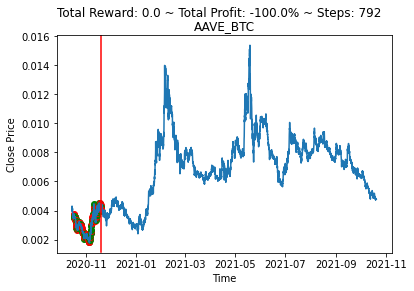

In [11]:
env = CryptoTradingEnv(pair_data, pair_name, max_stake_count=1)
observation = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

env.render()

Ran out of capital with 0 remaining open transactions. Environment is now done.
Rendering the environment results now. 8852 close price points and 1352 transaction points. This may take a while.


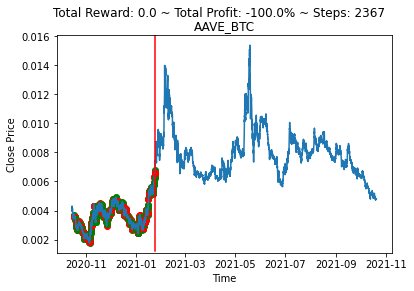

In [12]:
env = CryptoTradingEnv(pair_data, pair_name, max_stake_count=3)
observation = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

env.render()